# Introduction to Python and the GraphBLAS

## by Michel Pelletier

https://github.com/Graphegon/pygraphblas


[![](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Graphegon/pygraphblas/v4.0.3?filepath=pygraphblas%2Fdemo%2FIntroduction-to-GraphBLAS-with-Python.ipynb)


In [1]:
from pygraphblas import *       # import pygraphblas as grb
from pygraphblas.gviz import *

name = 'SIAM'

print(f'Hello {name}!')   # I use comments for speaker notes.

Hello SIAM!


# The Graph Matrix Duality

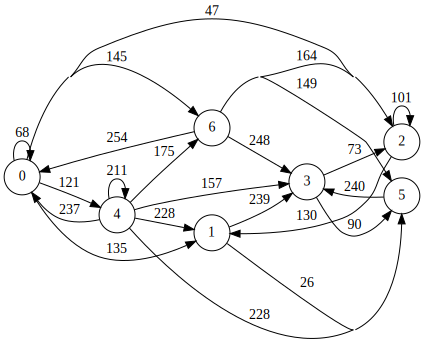

In [30]:
A = Matrix.random(UINT8, 7, 7, 30)
draw(A, graph_attr=dict(len='2'))

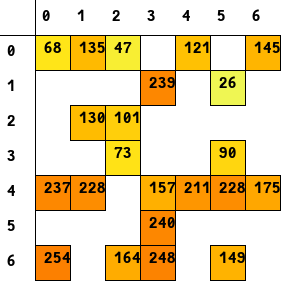

In [31]:
draw_matrix(A, scale=35, labels=True, cmap="Wistia", axes_labels=True)

# Matrix Multiplication is one Step Breadth First Search

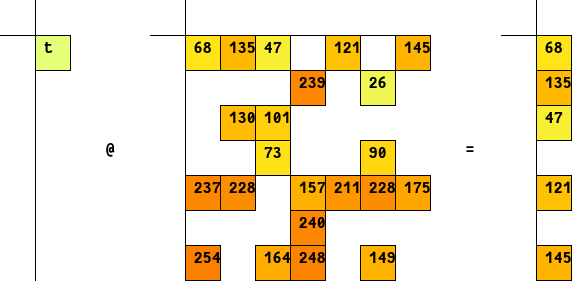

In [32]:
v = Vector.from_lists([0], [True], A.nrows)

#draw_matrix_op(A, '@', v, A @ v, scale=35, cmap="Wistia", labels=True)
draw_matrix_op(v, '@', A, v @ A, scale=35, cmap="Wistia", labels=True)

# BFS is Iteration of Multiplication

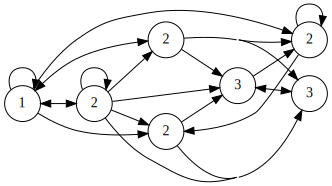

In [33]:
def bfs(A, start):
    v = Vector.sparse(UINT8, A.nrows)   # the result vector
    q = Vector.sparse(BOOL, A.nrows)    # a vector to keep track of known nodes
    q[start] = True                     # set the starting node
    level = 1                           # set the starting level
    A_nrows = A.nrows                   # Stop after all nodes
    while q.nvals and level <= A_nrows: # while there is work to do:
        v[q] = level                    #     Assign the current level to known (q) nodes in v
        v.vxm(A,                        #     v @ A
              mask=v,                   #     use known nodes as mask
              desc=descriptor.RC,       #     compliment the mask to only find *unknown* nodes
              out=q)                    #     update q, replace with next wavefront
        level += 1                      #     increment level
    return v
draw(A, show_weight=False, label_vector=bfs(A, 0))

# Shortest Path Length

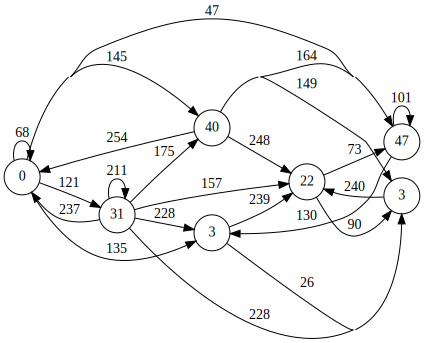

In [34]:

def shortest_path_length(A, start):
    v = Vector.sparse(A.type, A.nrows)      # Result vector
    v[start] = 0                            # Set starting position to 0

    with UINT8.MIN_PLUS, Accum(UINT8.MIN):  # MIN_PLUS semiring, MIN accumulator
        for _ in range(A.nrows):            # for every node:
            w = Vector.dup(v)               #     dup results
            v.vxm(A, out=v)                 # v @= A                         # v.vxm(matrix, out=v, accum=..., semiring=)    accumulate minimum of next level
            if w.iseq(v):                         #     if nothing changed:
                break                             #         we're done
        return v

draw(A, label_vector=shortest_path_length(A, 0))

# Union

The union operator `|` combines all elements two graphs. 

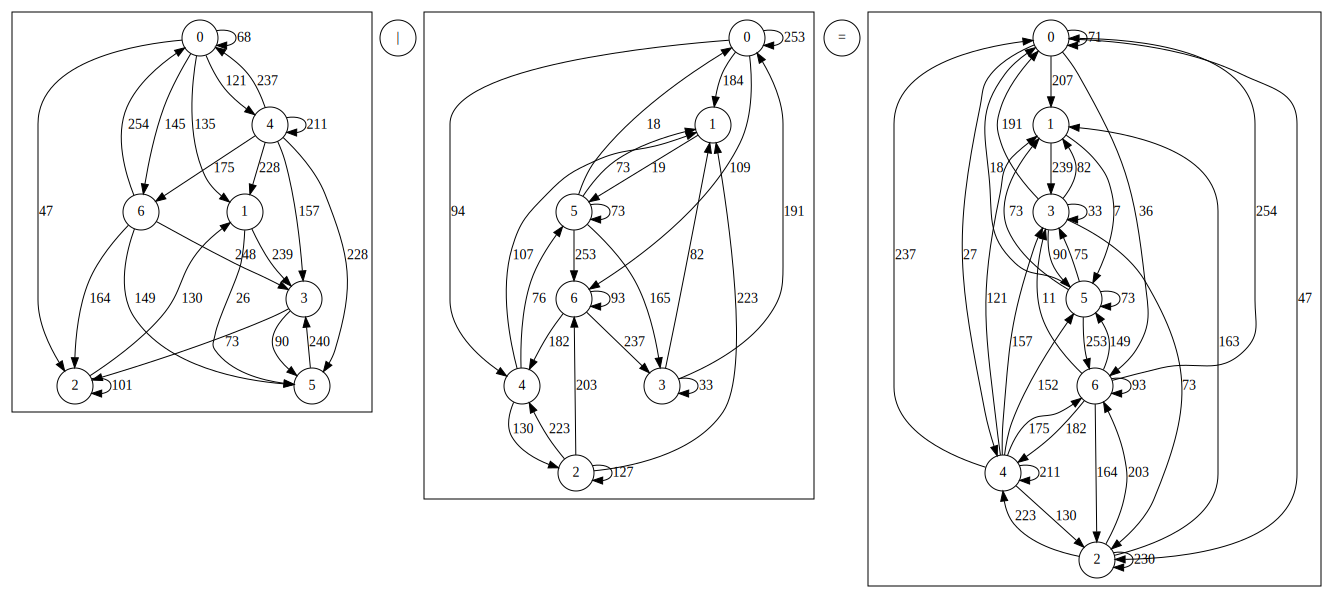

In [35]:
B = Matrix.random(UINT8, 7, 7, 30)

C = A - B
draw_graph_op(A, '|', B, C)

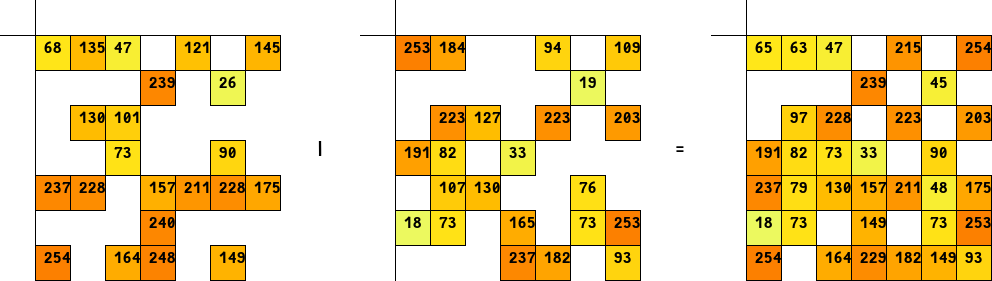

In [36]:
with INT64.PLUS:
    C = A | B
draw_matrix_op(A, '|', B, C, scale=35, cmap="Wistia")

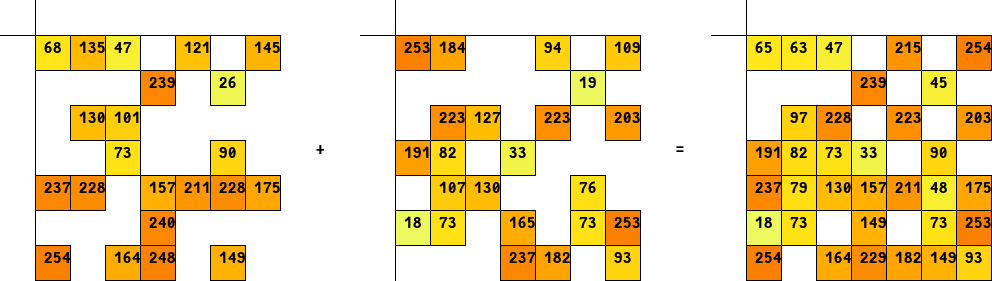

In [37]:
C = A + B
draw_matrix_op(A, '+', B, C, scale=35, cmap="Wistia")

# Intersection

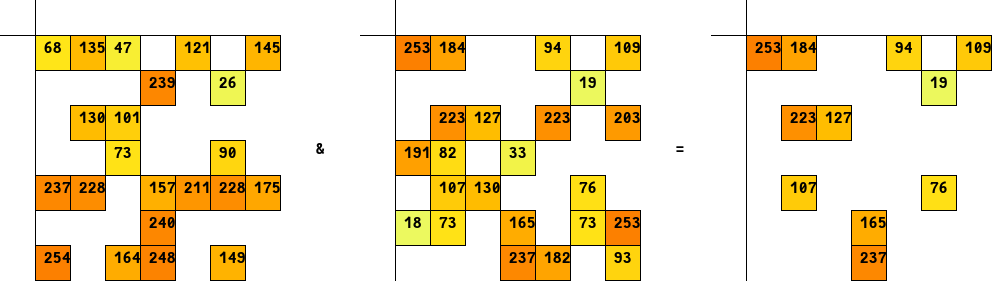

In [38]:
C = A & B
draw_matrix_op(A, '&', B, C, scale=35, cmap="Wistia")

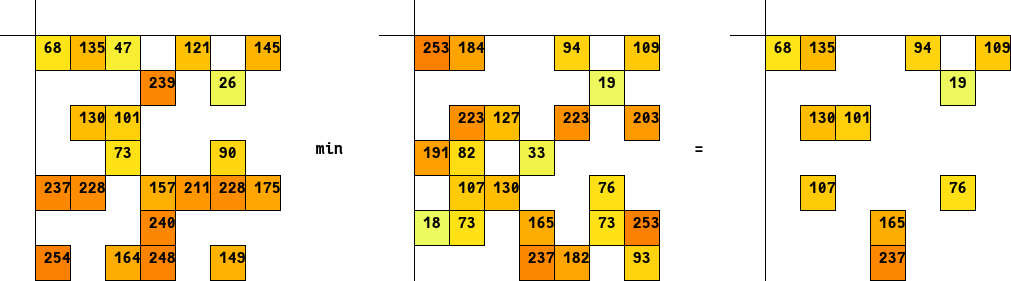

In [39]:
with INT64.MIN:
    C = A & B
draw_matrix_op(A, 'min', B, C, scale=35, cmap="Wistia")

# Matrix Matrix Multiplication

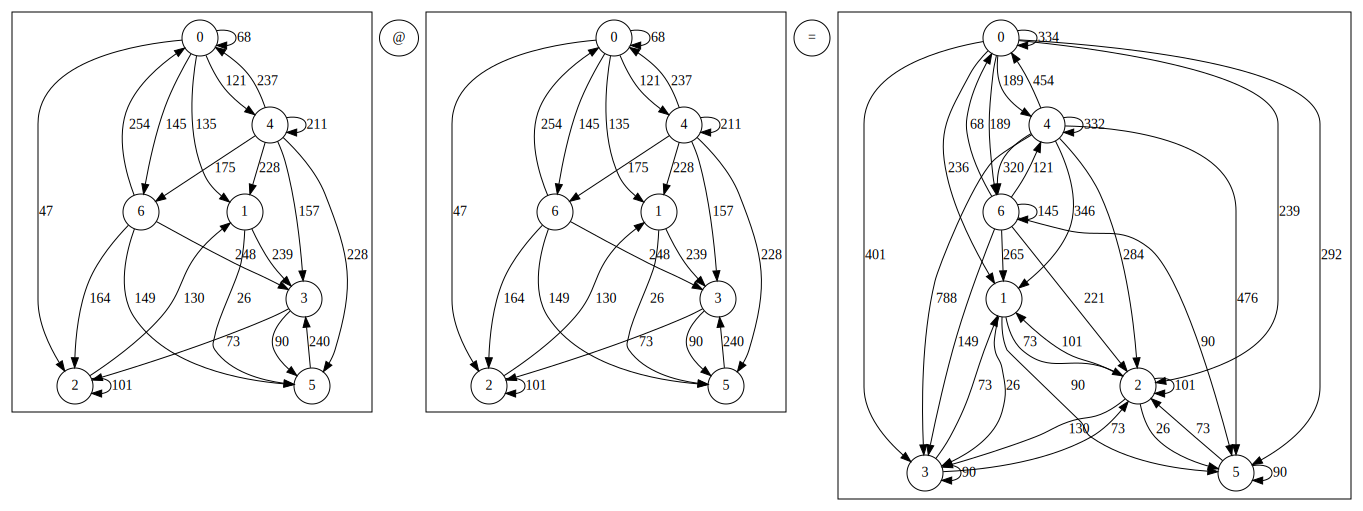

In [40]:
with INT64.PLUS_MIN:
    C = A @ A
draw_graph_op(A, '@', A, C)

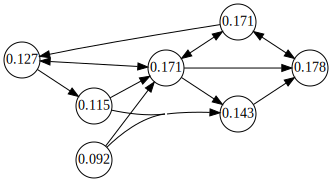

In [42]:
def pagerank(A, damping, itermax):
    n = A.nrows
    r = Vector.sparse(FP32, n)
    t = Vector.sparse(FP32, n)
    d = A.reduce_vector(FP32.PLUS_MONOID)
    d.assign_scalar(damping, accum=FP32.DIV)
    r[:] = 1.0 / n
    teleport = (1 - damping) / n
    tol = 1e-4
    rdiff = 1.0
    for i in range(itermax):
        temp = t ; t = r ; r = temp
        w = t / d
        r[:] = teleport
        A.mxv(w, out=r, accum=FP32.PLUS, semiring=FP32.PLUS_SECOND,
              desc=descriptor.T0)
        t -= r
        t.apply(FP32.ABS, out=t)
        rdiff = t.reduce_float()
        if rdiff <= tol:
            break
    return r

M = Matrix.random(FP32, 7, 7, 30, no_diagonal=True, make_pattern=True, seed=42)
pr = pagerank(M, 0.35, 3)
draw(M, label_vector=pr, show_weight=False, label_width=5)

# Sparse Deep Neural Networks

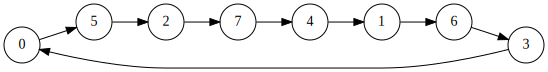

In [14]:
def permutation_matrix(size):
    P = Matrix.sparse(FP64, size, size)    
    P[size-1,0] = 1.0
    for i in range(size-1):
        P[i,i+1] = 1.0
    return P

draw(permutation_matrix(8)**5, show_weight=False)

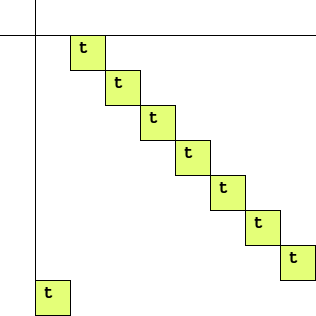

In [15]:
draw_matrix(permutation_matrix(8).pattern(), scale=35, cmap="Wistia")

In [16]:
from functools import reduce
from operator import attrgetter, mul

import imageio
from IPython.core.display import Image


def hypergraph(mt, frames=None, scale=1):
    size = sum(map(attrgetter('nrows'), mt)) + mt[0].nrows
    r = Matrix.sparse(FP32, size, size)
    ioffset = 0
    joffset = 0
    for m in mt:
        joffset += m.nrows
        for c, (i, j, k) in enumerate(m):
            r[i + ioffset, j + joffset] = k
        if frames is not None:
            frames.append(draw_matrix(r.pattern(), scale=scale, labels=False, cmap="Wistia"))
        ioffset += m.nrows
    return r

def mixed_topo_radix(topos, frames=None):
    sizes = [reduce(mul, x) for x in topos]
    size = sizes[0]
    layers = []
    P = permutation_matrix(size)    
    for t in topos:
        place_value = 1
        for n in t:
            layer = Matrix.sparse(FP64, size, size)
            for j in range(n):
                layer += (P ** (j*place_value))
            place_value *= n
            layers.append(layer)      
    return layers

def radixnet(topos, spec):
    return [d.kronecker(w) 
            for d, w in 
            zip(mixed_topo_radix(topos), ddnn(spec))]



240


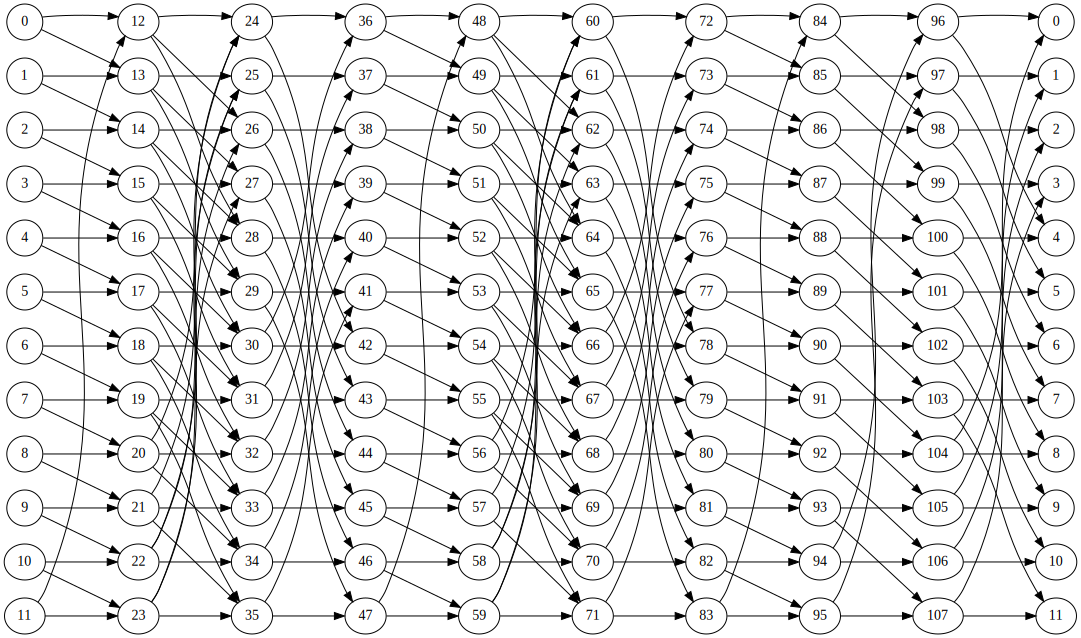

In [56]:
spec = [[2,3,2],[2,3,2],[2,2,2]]
from operator import mul
mt = mixed_topo_radix(spec)
print(12*2 + 12*3 + 12*2 +12*2 + 12*3 + 12*2 + 12*2 + 12*2 + 12*2)
draw_layers(mt)

In [43]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

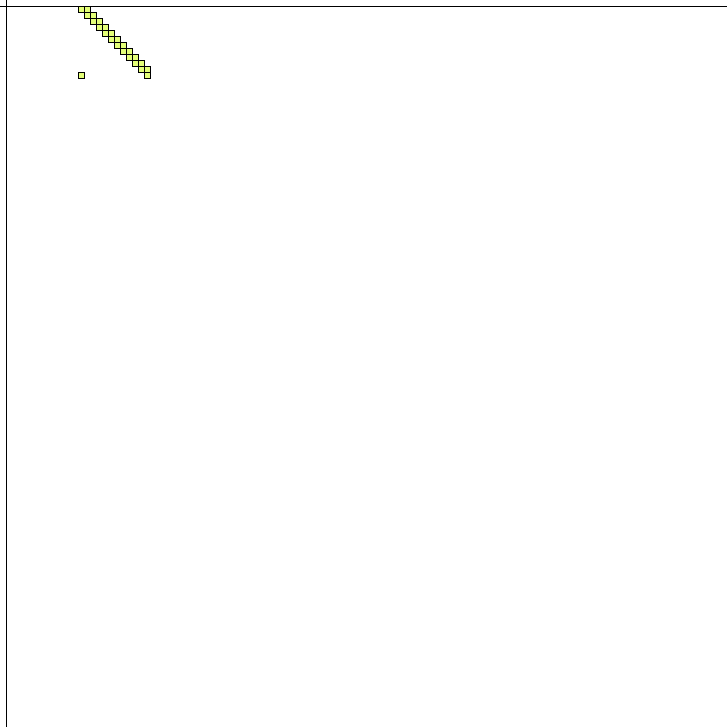

In [18]:
frames = []    
T = mixed_topo_radix(spec)
HT = hypergraph(T, frames, scale=6)
imageio.mimwrite('animated_from_images.gif', frames, fps=3)
display(Image('animated_from_images.gif'))

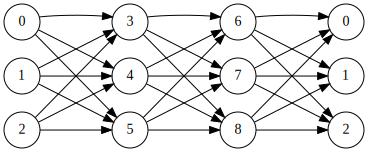

In [19]:
def ddnn(spec):
    return [Matrix.dense(FP64, spec[i], spec[i+1])
            for i in 
            range(len(spec) - 1)]

d = ddnn([3,3,3,3])
draw_layers(d)

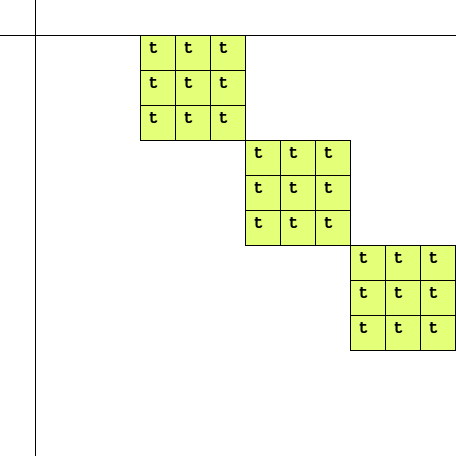

In [20]:
draw_matrix(hypergraph(d).pattern(), scale=35, cmap="Wistia")

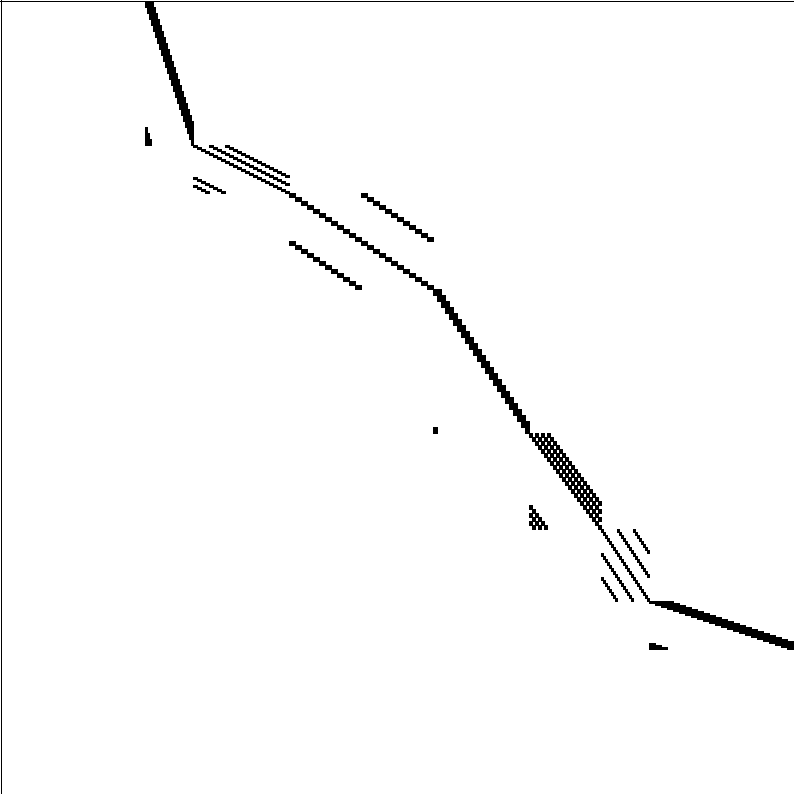

In [21]:
spec = [[4,3,2],[2,4,4],[4,3,4]]
t = [6,2,4,6,4,3,2,6]
R = radixnet(spec, t)
frames = []
HR = hypergraph(R)
#imageio.mimwrite('animated_from_images.gif', frames, fps=3)
#display(Image('animated_from_images.gif'))
draw_matrix(HR, scale=1)